In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import itertools
import xarray as xr
from Datasets import wind_order_forcings, exp_set_dict_wind_order, colors_dict
import Functions_data_analysis as fda
import Functions_load_output as flo
import Functions_plotting as fp

In [15]:
# Use importlib to reload modules after editing them
import importlib
importlib.reload(fp)

<module 'Functions_plotting' from '/glade/campaign/univ/ulnl0002/Gemma/Analysis/Functions_plotting.py'>

In [3]:
cdw_min_temp = 0.5 #degrees celsius

# choose region from shelf_region_dict in fda
# region = 'thesis_shelf_box'
region = 'naughten_shelf_box'

# sets = ['ic_1995','ic_2001','ic_2008']
sets = ['control','ic_1995','ic_2001','ic_2008']
forcings = wind_order_forcings

n_months = 60 # if None, uses all data in runs. set to make it consistent

In [4]:
runs_nested = [exp_set_dict_wind_order[set] for set in sets]
runs = [run for sublist in runs_nested for run in sublist]

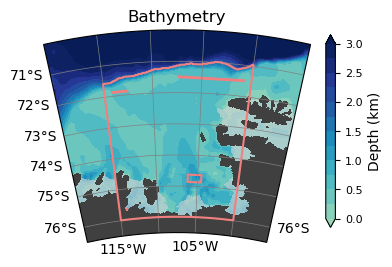

In [40]:
# Show locations of cross sections on bathymetry map
# importlib.reload(fp)
fig = fp.plot_bathymetry_and_locs('bathy_map',[region,'COT','EOT','PITT']) 
fig.savefig('Plots/GRL_figs/Figure_1a_bathymetry_map_with_locs.png',dpi=400)

In [6]:
# Calculate grid sizes for first experiment ahead of time so don't have to redo for each run
exp1_ds = flo.load_experiment_ds(runs[1], 'all', 'state_3d_set2')
if n_months != None:
    run_ds = exp1_ds.isel(time = slice(0,n_months))

# Only look at data between 200m and 1500m depth to exclude surface water and deep ocean
exp1_T_raw = exp1_ds.THETA
exp1_T_mid_depths = exp1_T_raw.sel(depth=slice(-200,-1500))

# Select data from shelf region
if region in fda.shelf_region_dict.keys():
    lat1,lat2,lon1,lon2 = fda.shelf_region_dict[region]
    exp1_T = exp1_T_mid_depths.sel(lat = slice(lat1,lat2),lon=slice(lon1,lon2))
shelf_grid_areas = fda.calc_grid_areas(exp1_T)
shelf_grid_areas.shape

distance between first set of lats: -70.81403 -70.839806 : 2865.726182596398 meters
distance between first set of lons: -114.958336 -114.875 , 9266.526670368372 meters


(213, 180)

In [7]:
importlib.reload(fda)

# Load or calculate CDW volume timeseries for all runs
cdw_volumes = []
times_list = []
labs = []
for run in runs:
    print(run)
    # try loading precalc CDW volume
    try:
        cdw_vol = np.load('Saved Arrays/CDW_Volume/'+run+'_'+str(cdw_min_temp)+'deg_'+region+'.npy')
        if run == 'control':
            vol_times = np.load('Saved Arrays/CDW_Volume/times_control.npy')
            labs.append('control')
        else:
            ic_set = run.split('rep_ic_')[1]
            vol_times = np.load('Saved Arrays/CDW_Volume/times_ic_'+ic_set+'.npy')
            labs.append(run.split('run_forc_erai_')[1][0:4])
    # Otherwise, calculate from scratch and save arrays
    except:
        print('run CDW volume not saved. calculating...')
        if run != 'control':
            vol_times, cdw_vol = fda.calc_cdw_volume_tseries(run, region, cdw_min_temp, shelf_grid_areas, n_months = n_months)
            save_name = 'Saved Arrays/CDW_Volume/'+run+'_'+str(cdw_min_temp)+'deg_'+region+'.npy'
            print('Saving new CDW volume array as ',save_name)
            np.save(save_name,cdw_vol)
            ic_set = run.split('rep_ic_')[1]
            try:
                vol_times = np.load('Saved Arrays/CDW_Volume/times_ic_'+ic_set+'.npy')
            except:
                np.save('Saved Arrays/CDW_Volume/times_ic_'+ic_set+'.npy',vol_times)
        else:
            labs.append('control')
            # load full run for control run
            vol_times, cdw_vol = fda.calc_cdw_volume_tseries(run, region, cdw_min_temp, shelf_grid_areas)
            save_name = 'Saved Arrays/CDW_Volume/'+run+'_'+str(cdw_min_temp)+'deg_'+region+'.npy'
            print('Saving new CDW volume array as ',save_name)
            np.save(save_name,cdw_vol)
            np.save('Saved Arrays/CDW_Volume/times_control.npy',vol_times)
   
    cdw_volumes.append(cdw_vol)
    times_list.append(vol_times)


control
run_forc_erai_2015_rep_ic_1995
run_forc_erai_1991_rep_ic_1995
run_forc_erai_1982_rep_ic_1995
run_forc_erai_1994_rep_ic_1995
run_forc_erai_1992_rep_ic_1995
run_forc_erai_1984_rep_ic_1995
run_forc_erai_2009_rep_ic_1995
run_forc_erai_2003_rep_ic_1995
run_forc_erai_1989_rep_ic_1995
run_forc_erai_2011_rep_ic_1995
run_forc_erai_2015_rep_ic_2001
run_forc_erai_1991_rep_ic_2001
run_forc_erai_1982_rep_ic_2001
run_forc_erai_1994_rep_ic_2001
run_forc_erai_1992_rep_ic_2001
run_forc_erai_1984_rep_ic_2001
run_forc_erai_2009_rep_ic_2001
run_forc_erai_2003_rep_ic_2001
run_forc_erai_1989_rep_ic_2001
run_forc_erai_2011_rep_ic_2001
run_forc_erai_2015_rep_ic_2008
run_forc_erai_1991_rep_ic_2008
run_forc_erai_1982_rep_ic_2008
run_forc_erai_1994_rep_ic_2008
run_forc_erai_1992_rep_ic_2008
run_forc_erai_1984_rep_ic_2008
run_forc_erai_2009_rep_ic_2008
run_forc_erai_2003_rep_ic_2008
run_forc_erai_1989_rep_ic_2008
run_forc_erai_2011_rep_ic_2008


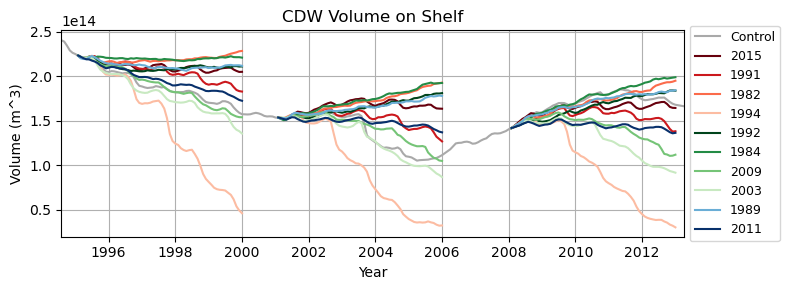

In [8]:
# decide whether to plot all runs (for animating plots in talks)

# plot_labels = ['control']
# plot_labels = ['control','2015']
# plot_labels = ['control','2015','2011']
plot_labels = labs

colors_list = [colors_dict[set] for set in sets]
colors = [item for sublist in colors_list for item in sublist]

fig = plt.figure()
fig.set_size_inches((8,3))
ax=plt.subplot(1,1,1)
labels = [] #for mean plot below
for i in range(len(runs)):
    # print(i,runs[i])
    run = runs[i]
    if run == 'control':
        if run in plot_labels:
            ax.plot(times_list[i], cdw_volumes[i], label='Control', color = 'darkgray')
            labels.append(run)
    elif i < 11:
        label = run.split('run_forc_erai_')[1][0:4]
        if label in plot_labels:
            ax.plot(times_list[i], cdw_volumes[i], label=label, color = colors[i])
            labels.append(label)
    else:
        label = run.split('run_forc_erai_')[1][0:4]
        if label in plot_labels:
            ax.plot(times_list[i][0:n_months], cdw_volumes[i][0:n_months], color = colors[i])
            labels.append(label)

# ax.set_ylim(0.5e11,1.52e11)
ax.set_ylabel('Volume (m^3)')
ax.grid()
ax.set_xlabel('Year')
ax.set_xlim(np.datetime64('1994-08-01'),np.datetime64('2013-04-01'))
plt.title('CDW Volume on Shelf')

ax.legend(ncol=1,fontsize=9,loc='center left',bbox_to_anchor=[1,0.5])

plt.subplots_adjust(top=0.95,bottom=0.06,hspace=0.2,wspace=.25,left=0.08,right=.97)
plt.tight_layout()
# plt.savefig('Plots/Figure_CDW_volume_on_shelf.png',dpi=600)

In [21]:
vol_means = [np.mean(i) for i in cdw_volumes]
vol_stds = [np.std(i) for i in cdw_volumes]
for value,run in zip(vol_means,runs):
    formatted_value = "{:.2e}".format(value)
    # print(formatted_value,run)

In [43]:
#THERES A BUG... THE RUNS DON'T LINE UP. CHECK THAT 1994 AND INDEXING ARE HANDLED CORRECTLY.and that delta calc is correct.

# calculate mean in 1995 ensemble and determine if any are outside of 2sigma
# trim to exclude control and 1994
cdw_volumes_trim = cdw_volumes[1:4]+cdw_volumes[5:14]+cdw_volumes[15:24]+cdw_volumes[25:31]
cdw_vol_means_trim = [np.mean(i) for i in cdw_volumes_trim]
runs_trim = runs[1:4]+runs[5:14]+runs[15:24]+runs[25:31]

#calculate delta cdw volume from last value to initial condition
cdw_delta_vol_means = [vol[-1] - vol[0] for vol in cdw_volumes_trim]
print(cdw_delta_vol_means)

def search_sig_runs(cdw_volumes,runs):
    
    set_mean = np.mean(cdw_volumes)
    set_2sig = 2*np.std(cdw_volumes)
    print(f"searching for volumes greater than {set_mean + set_2sig:.2e}")
    sig_runs = []
    for value,run in zip(cdw_volumes,runs):
        # print(run+f", value: {value:.2e}")
        if value > (set_mean + set_2sig):
            print(run, value)
            sig_runs.append(run)
        if value < (set_mean - set_2sig):
            print(run, value, 'less than 2sigma')
    return sig_runs

ic_1995_sig_cdw_runs = search_sig_runs(cdw_vol_means_trim[0:9],runs[0:9])
ic_2001_sig_cdw_runs = search_sig_runs(cdw_vol_means_trim[9:18],runs[9:18])
ic_2008_sig_cdw_runs = search_sig_runs(cdw_vol_means_trim[18:27],runs[18:27])

# search if any significant runs in terms of delta volume
ic_1995_sig_cdw_runs = search_sig_runs(cdw_delta_vol_means[0:9],runs[0:9])
ic_2001_sig_cdw_runs = search_sig_runs(cdw_delta_vol_means[9:18],runs[9:18])
ic_2008_sig_cdw_runs = search_sig_runs(cdw_delta_vol_means[18:27],runs[18:27])

        

[-9129109752.03955, -24395254945.81839, 9968311699.221832, -5755422845.405914, 3750480827.0931854, -37132564356.61871, -57570574365.452835, -3830320864.131607, -32147097299.325806, 2793587942.6707916, -27917508059.12845, 23137566093.086624, 12321368300.823593, 19870481507.007217, -47180735404.10144, -71041928947.0714, 10829838667.24936, -20797383054.779144, 11206483655.60347, -9318680042.238495, 32287614484.573883, 22029764680.75116, 31091546309.250427, -31433463913.892815, -55661734392.95095, 20326323138.483017, -13266398530.67128]
searching for volumes greater than 1.47e+11
run_forc_erai_1984_rep_ic_1995 111717965947.32437 less than 2sigma
searching for volumes greater than 1.21e+11
run_forc_erai_1992_rep_ic_2001 74784474462.10422 less than 2sigma
searching for volumes greater than 1.23e+11
run_forc_erai_1994_rep_ic_2008 76513570849.7615 less than 2sigma
searching for volumes greater than 2.40e+10
searching for volumes greater than 5.10e+10
searching for volumes greater than 5.81e+10

In [44]:
# calculate delta cdw volume in each ensemble and determine if any are outside of 2sigma
# exclude 1994
ic_1995_mean = np.mean(vol_means[1:4]+vol_means[5:11])
ic_1995_2sig = 2*np.std(vol_means[1:4]+vol_means[5:11])
print(f"IC 1995 CDW volume mean (for all 5 years and 2 sigma level: {ic_1995_mean:.2e}, {ic_1995_2sig:.2e}")
print(f"searching for volumes greater than {ic_1995_mean + ic_1995_2sig:.2e}")
for value,run in zip(vol_means[1:4]+vol_means[5:11],runs[1:4]+runs[5:11]):
    # print(run+f", value: {value:.2e}")
    if value > ic_1995_mean + ic_1995_2sig:
        print(run, value)
        
ic_2001_mean = np.mean(vol_means[11:14]+vol_means[15:21])
ic_2001_2sig = 2*np.std(vol_means[11:14]+vol_means[15:21])
print(f"IC 2001 CDW volume mean (for all 5 years and 2 sigma level: {ic_2001_mean:.2e}, {ic_2001_2sig:.2e}")
print(f"searching for volumes greater than {ic_2001_mean + ic_2001_2sig:.2e}")
for value,run in zip(vol_means[11:14]+vol_means[15:21],runs[11:14]+runs[15:21]):
    # print(run+f", value: {value:.2e}")
    if value > ic_2001_mean + ic_2001_2sig:
        print(run, value)
        
ic_2008_mean = np.mean(vol_means[21:24]+vol_means[25:31])
ic_2008_2sig = 2*np.std(vol_means[21:24]+vol_means[25:31])
print(f"IC 2008 CDW volume mean (for all 5 years and 2 sigma level: {ic_2008_mean:.2e}, {ic_2008_2sig:.2e}")
print(f"searching for volumes greater than {ic_2008_mean + ic_2008_2sig:.2e}")
for value,run in zip(vol_means[21:24]+vol_means[25:31],runs[21:24]+runs[25:31]):
    # print(run+f", value: {value:.2e}")
    if value > ic_2008_mean + ic_2008_2sig:
        print(run, value)

IC 1995 CDW volume mean (for all 5 years and 2 sigma level: 1.29e+11, 1.75e+10
searching for volumes greater than 1.47e+11
IC 2001 CDW volume mean (for all 5 years and 2 sigma level: 9.87e+10, 2.27e+10
searching for volumes greater than 1.21e+11
IC 2008 CDW volume mean (for all 5 years and 2 sigma level: 9.97e+10, 2.31e+10
searching for volumes greater than 1.23e+11


In [31]:
# calculate mean of all 30 ensembles and look for >2sigma runs
all_ens_mean_vol = np.mean(cdw_volumes[1:])
all_ens_std_vol = np.std(cdw_volumes[1:])
print(f"CDW volume mean (for all 5 years and 2 sigma level: {all_ens_mean_vol:.2e}, {all_ens_std_vol:.2e}")
print(f"searching for volumes greater than {all_ens_mean_vol + all_ens_std_vol:.2e}")
for value,run in zip(vol_means[1:],runs[1:]):
    # print(run+f", value: {value:.2e}")
    if value > all_ens_mean_vol + all_ens_std_vol:
        print(run, value)

CDW volume mean (for all 5 years and 2 sigma level: 1.04e+11, 2.79e+10
searching for volumes greater than 1.32e+11
run_forc_erai_2015_rep_ic_1995 132501001278.76974
run_forc_erai_1982_rep_ic_1995 140450779868.11478
run_forc_erai_1992_rep_ic_1995 132368018592.22151
run_forc_erai_1984_rep_ic_1995 139745226824.69354
run_forc_erai_1989_rep_ic_1995 134623682578.78267


<Figure size 640x480 with 0 Axes>

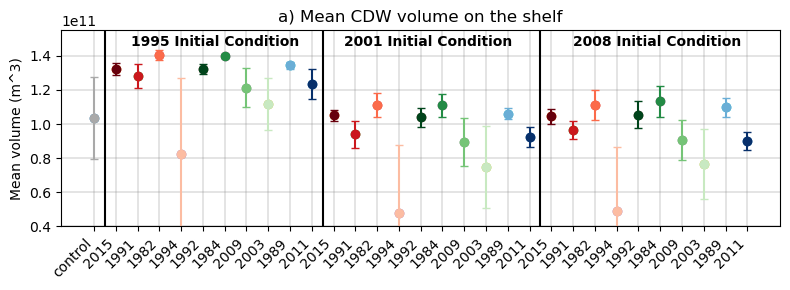

In [124]:
# Plot mean CDW vol for all 5 years 

fig = plt.figure()
fig,ax = plt.subplots()
for i in range(len(runs)):
    # print(run_names[i],vol_means[i],vol_stds[i])
    ax.scatter(runs[i],vol_means[i])
    ax.errorbar(runs[i],vol_means[i], yerr=vol_stds[i], fmt="o",capsize=3,color=colors[i])
ax.set_xticks(ax.get_xticks(), labels, rotation=45, ha='right')
plt.axvline(x=0.5,color='k')
plt.axvline(x=10.5,color='k')
plt.axvline(x=20.5,color='k')
plt.ylabel('Mean volume (m^3)')
plt.grid(color='gray',linewidth=0.3)
plt.title('a) Mean CDW volume on the shelf')
plt.text(1.7,1.46e11,'1995 Initial Condition',fontweight='bold')
plt.text(11.5,1.46e11,'2001 Initial Condition',fontweight='bold')
plt.text(22,1.46e11,'2008 Initial Condition',fontweight='bold')
plt.ylim(0.4e11,1.55e11)
fig.set_size_inches((8,3))
plt.tight_layout()
plt.savefig('Plots/Figure_CDW_volume_means.png',dpi=400)

<Figure size 640x480 with 0 Axes>

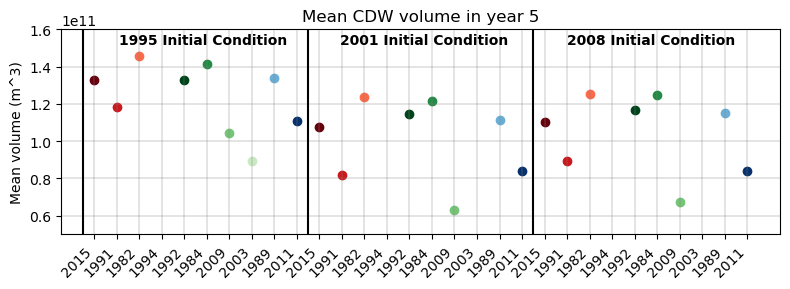

In [100]:
# Plot the mean CDW using just the 5th year in each simulation, so you're not tied to the initial condition
# index past one to exclude the control run
vol_means_yr5 = [np.mean(i[51:]) for i in cdw_volumes][1:]
vol_stds_yr5 = [np.std(i[51:]) for i in cdw_volumes][1:]

fig = plt.figure()
fig,ax = plt.subplots()
for i in range(len(runs[1:])):
    # print(run_names[i],vol_means[i],vol_stds[i])
    ax.scatter(runs[i],vol_means_yr5[i],color=colors[i+1])
    # ax.errorbar(runs[i],vol_means_yr5[i], yerr=vol_stds_yr5[i], fmt="o",capsize=3,color=colors[i+1])
ax.set_xticks(ax.get_xticks(), labels[1:], rotation=45, ha='right')
plt.axvline(x=-0.5,color='k')
plt.axvline(x=9.5,color='k')
plt.axvline(x=19.5,color='k')
plt.ylabel('Mean volume (m^3)')
plt.grid(color='gray',linewidth=0.3)
plt.title('Mean CDW volume in year 5')
plt.text(1.1,1.52e11,'1995 Initial Condition',fontweight='bold')
plt.text(10.9,1.52e11,'2001 Initial Condition',fontweight='bold')
plt.text(21,1.52e11,'2008 Initial Condition',fontweight='bold')
plt.ylim(0.5e11,1.6e11)
fig.set_size_inches((8,3))
plt.tight_layout()
plt.savefig('Plots/Figure_CDW_volume_mean_yr5.png',dpi=400)

run_forc_erai_2015_rep_ic_1995: -6.66%
run_forc_erai_1991_rep_ic_1995: -17.78%
run_forc_erai_1982_rep_ic_1995: 7.28%
run_forc_erai_1994_rep_ic_1995: -96.40%
run_forc_erai_1992_rep_ic_1995: -4.19%
run_forc_erai_1984_rep_ic_1995: 2.74%
run_forc_erai_2009_rep_ic_1995: -27.04%
run_forc_erai_2003_rep_ic_1995: -41.97%
run_forc_erai_1989_rep_ic_1995: -2.80%
run_forc_erai_2011_rep_ic_1995: -23.41%
run_forc_erai_2015_rep_ic_2001: 2.77%
run_forc_erai_1991_rep_ic_2001: -27.58%
run_forc_erai_1982_rep_ic_2001: 22.91%
run_forc_erai_1994_rep_ic_2001: -99.36%
run_forc_erai_1992_rep_ic_2001: 12.18%
run_forc_erai_1984_rep_ic_2001: 19.69%
run_forc_erai_2009_rep_ic_2001: -46.66%
run_forc_erai_2003_rep_ic_2001: -70.22%
run_forc_erai_1989_rep_ic_2001: 10.73%
run_forc_erai_2011_rep_ic_2001: -20.54%
run_forc_erai_2015_rep_ic_2008: 11.91%
run_forc_erai_1991_rep_ic_2008: -9.90%
run_forc_erai_1982_rep_ic_2008: 34.44%
run_forc_erai_1994_rep_ic_2008: -99.72%
run_forc_erai_1992_rep_ic_2008: 23.43%
run_forc_erai_198

<Figure size 640x480 with 0 Axes>

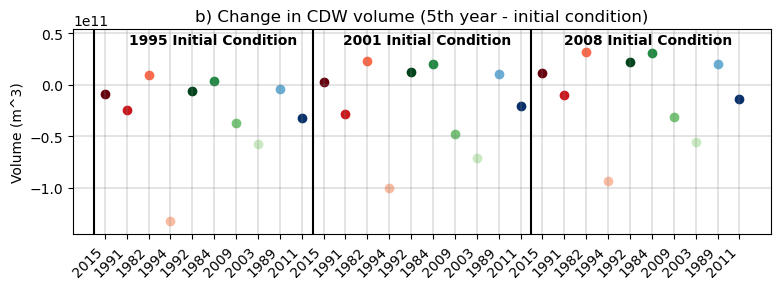

In [139]:
# Plot the delta CDW using (last value minus 0th value) in each simulation
# index past one to exclude the control run
delta_vol = [i[-1]-i[0] for i in cdw_volumes][1:]
fract_increase = [(i[-1]-i[0])/i[0] for i in cdw_volumes][1:]
for i in range(len(runs[1:])):
    print(runs[1:][i]+': {:.2f}%'.format(fract_increase[i]*100))
# vol_stds_yr5 = [np.std(i[51:]) for i in cdw_volumes][1:]

fig = plt.figure()
fig,ax = plt.subplots()
for i in range(len(runs[1:])):
    # print(run_names[i],vol_means[i],vol_stds[i])
    ax.scatter(runs[i+1],delta_vol[i],color=colors[i+1])
    # ax.errorbar(runs[i+1],vol_means_yr5[i], yerr=vol_stds_yr5[i], fmt="o",capsize=3,color=colors[i+1])

ax.set_xticks(ax.get_xticks(), labels[1:], rotation=45, ha='right')
plt.axvline(x=-0.5,color='k')
plt.axvline(x=9.5,color='k')
plt.axvline(x=19.5,color='k')
plt.ylabel('Volume (m^3)')
plt.grid(color='gray',linewidth=0.3)
plt.title('b) Change in CDW volume (5th year - initial condition)')
plt.text(1.1,0.4e11,'1995 Initial Condition',fontweight='bold')
plt.text(10.9,0.4e11,'2001 Initial Condition',fontweight='bold')
plt.text(21,0.4e11,'2008 Initial Condition',fontweight='bold')
plt.ylim(-1.45e11,0.54e11)
fig.set_size_inches((8,3))
plt.tight_layout()
plt.savefig('Plots/Figure_delta_CDW_volume.png',dpi=400)

run_forc_erai_2015_rep_ic_1995: 27.25%
run_forc_erai_1991_rep_ic_1995: 12.18%
run_forc_erai_1982_rep_ic_1995: 46.05%
run_forc_erai_1994_rep_ic_1995: -95.09%
run_forc_erai_1992_rep_ic_1995: 30.78%
run_forc_erai_1984_rep_ic_1995: 40.03%
run_forc_erai_2009_rep_ic_1995: -0.41%
run_forc_erai_2003_rep_ic_1995: -20.86%
run_forc_erai_1989_rep_ic_1995: 32.24%
run_forc_erai_2011_rep_ic_1995: 4.56%
run_forc_erai_2015_rep_ic_2001: 82.86%
run_forc_erai_1991_rep_ic_2001: 29.18%
run_forc_erai_1982_rep_ic_2001: 118.73%
run_forc_erai_1994_rep_ic_2001: -98.85%
run_forc_erai_1992_rep_ic_2001: 99.98%
run_forc_erai_1984_rep_ic_2001: 112.80%
run_forc_erai_2009_rep_ic_2001: -4.97%
run_forc_erai_2003_rep_ic_2001: -46.91%
run_forc_erai_1989_rep_ic_2001: 97.00%
run_forc_erai_2011_rep_ic_2001: 41.79%
run_forc_erai_2015_rep_ic_2008: -1.06%
run_forc_erai_1991_rep_ic_2008: -20.29%
run_forc_erai_1982_rep_ic_2008: 18.47%
run_forc_erai_1994_rep_ic_2008: -99.75%
run_forc_erai_1992_rep_ic_2008: 9.09%
run_forc_erai_1984_

<Figure size 640x480 with 0 Axes>

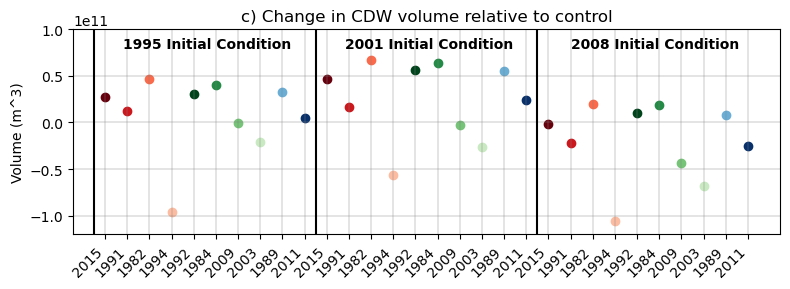

In [140]:
# Plot the delta CDW using relative to the control

# index past one to exclude the control run
delta_ctrl_vol = []
fract_delta_ctrl = []
for i in range(len(runs[1:])):
    # ic 1995
    if i < 10:
        ctrl_vol = cdw_volumes[0][94]
    # ic 2001
    elif i < 20:
        ctrl_vol = cdw_volumes[0][166]
    # ic 2008
    else:
        ctrl_vol = cdw_volumes[0][250]
    # calc last val of 5-yr run minus associated value in control run
    delta_ctrl = cdw_volumes[i+1][-1] - ctrl_vol
    delta_ctrl_vol.append(delta_ctrl)
    fract_delta_ctrl.append(delta_ctrl / ctrl_vol)
# vol_stds_yr5 = [np.std(i[51:]) for i in cdw_volumes][1:]

# print increases as percentages
for i in range(len(runs[1:])):
    print(runs[1:][i]+': {:.2f}%'.format(fract_delta_ctrl[i]*100))
    
fig = plt.figure()
fig,ax = plt.subplots()
for i in range(len(runs[1:])):
    # print(run_names[i],vol_means[i],vol_stds[i])
    ax.scatter(runs[i+1],delta_ctrl_vol[i],color=colors[i+1])
    # ax.errorbar(runs[i+1],vol_means_yr5[i], yerr=vol_stds_yr5[i], fmt="o",capsize=3,color=colors[i+1])
ax.set_xticks(ax.get_xticks(), labels[1:], rotation=45, ha='right')
plt.axvline(x=-0.5,color='k')
plt.axvline(x=9.5,color='k')
plt.axvline(x=19.5,color='k')
plt.ylabel('Volume (m^3)')
plt.grid(color='gray',linewidth=0.3)
plt.title('c) Change in CDW volume relative to control')
plt.text(0.8,0.8e11,'1995 Initial Condition',fontweight='bold')
plt.text(10.8,0.8e11,'2001 Initial Condition',fontweight='bold')
plt.text(21,0.8e11,'2008 Initial Condition',fontweight='bold')
plt.ylim(-1.2e11,1e11)
fig.set_size_inches((8,3))
plt.tight_layout()
plt.savefig('Plots/Figure_delta_ctrl_CDW_volume.png',dpi=400)

In [ ]:
# calculate mean std dev of each 


In [ ]:
# Testing is below

In [ ]:
# Load one run for testing: 1982_1995
run_ds = flo.load_experiment_ds('run_forc_erai_1982_rep_ic_1995', 'all', 'state_3d_set2')
exp_T_raw = run_ds.THETA
# roughly narrow down shelf region (refine later)
lat1,lat2,lon1,lon2 = fda.shelf_region_dict[region]
exp_T = exp_T_raw.sel(lat = slice(lat1,lat2),depth=slice(-200,-1500),lon=slice(lon1,lon2))
exp_T


In [ ]:
# binary mask water cooler than CDW temp 
exp_CDW_bin = xr.where(exp_T > cdw_min_temp, 1, 0) #shape (time, depth, lat, lon)
exp_CDW_bin = exp_CDW_bin.values #make it an np array
# mask to keep values (I don't care about the values here, just volume of CDW)
# exp_CDW_vals = exp_T.where(exp_T > cdw_min)
# exp_CDW_bin[0,:,0,0], exp_CDW_vals[0,:,0,0].values

# Calculate thicknesses of each layer
depths = exp_T.depth.values
layer_thicknesses = np.diff(-depths)

In [ ]:
# Calculate size of each grid cell
import math

def calculate_distance(coord1, coord2):
    # note coord1 and coord2 must be both lats or both lons (it subtracts them)
    # returns distance in km
    
    # Convert latitude or longitude values from degrees to radians
    coord1_rad = math.radians(coord1)
    coord2_rad = math.radians(coord2)

    # Earth radius in kilometers
    earth_radius = 6371.0

    # Calculate the difference (in lats or lons)
    dcoord = coord2_rad - coord1_rad

    # Calculate the distance using the Haversine formula
    distance = 2 * earth_radius * math.asin(math.sqrt(math.sin(dcoord/2)**2))

    return distance

n_lats, n_lons = len(exp_T.lat), len(exp_T.lon)
#n_lats,n_lons = 4,4
shelf_grid_areas = np.zeros((n_lats,n_lons))

# calculate area in each grid point in selected region
for i in range(n_lats-1):
    
    # Calculate lat distance of grid cell
    lat1,lat2 = exp_T.lat[i].values,exp_T.lat[i+1].values
    dist_i = calculate_distance(lat1,lat2)
    #print(lat1,lat2,dist_i)
    
    for j in range(n_lons-1):
        lon1,lon2 = exp_T.lon[j].values,exp_T.lon[j+1].values
        dist_j = calculate_distance(lon1,lon2)
        #print(lon1,lon2,dist_j)
        
        cell_area = dist_i * dist_j
        shelf_grid_areas[i,j] = cell_area
# shelf_grid_areas

In [ ]:
# calculate volume of CDW (everything not masked)

n_times = exp_T.shape[0]
n_lats, n_lons = len(exp_T.lat), len(exp_T.lon)
# n_times,n_lats,n_lons = 3,3,3
cdw_vol = np.zeros((n_times))
# calculate volume at each timestep
for t in range(n_times):
    # start counter for cdw on the shelf
    shelf_cdw_vol = 0
    # for each cell, calculate volume of cdw
    for i in range(n_lats):
        for j in range(n_lons):
            # get thicknesses of CDW with dot product of array containining CDW depths (1's) and array containing depth thicknesses
            # this sums the total thicknesses of CDW in the cell
            cdw_thickness = np.dot(exp_CDW_bin[t,:,i,j][0:-1],layer_thicknesses)
            # multiply thickness by grid area to get volume
            cell_cdw_vol = cdw_thickness * shelf_grid_areas[i,j]
            # add cell cdw vol to shelf counter
            shelf_cdw_vol += cell_cdw_vol
    cdw_vol[t] = shelf_cdw_vol

In [ ]:
# Plot timeseries of cdw_vol
times = exp_T.time.values
times_dt64 = [np.datetime64(x) for x in times]
plt.plot(times_dt64,cdw_vol)